<a href="https://colab.research.google.com/github/supriyag123/PHD_Pub/blob/main/CLAUDE_METROPM_Step1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

AUTOMATED PIPELINE COMPLETED!
Final dataset: 3627 sequences, 50 timesteps, 13 features
Window range: 1 to 25
Files saved with -AUTO suffix


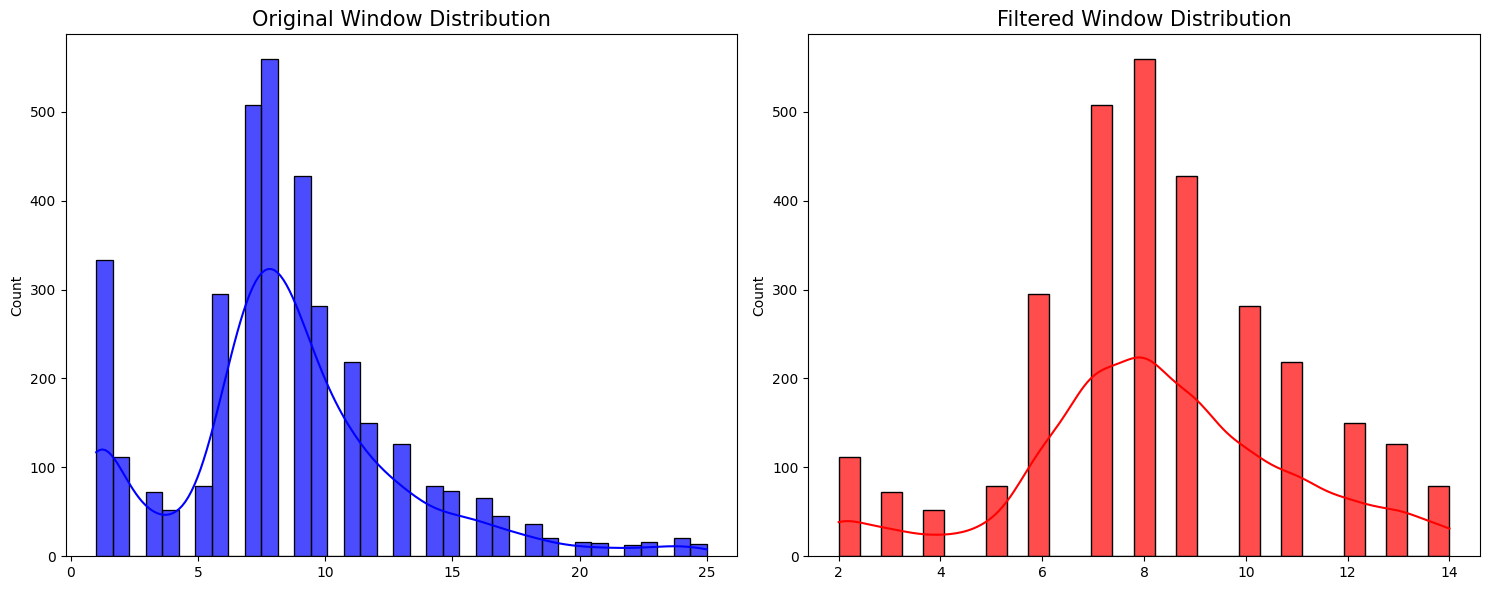

Pipeline ready for new datasets - no manual intervention needed!


In [50]:
!pip install statsmodels --upgrade
!pip install -U lingam
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import math
import plotly.graph_objects as go
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed, Input
from keras.models import Model
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
import ast
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LassoCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import TimeSeriesSplit
from numpy import arange
import warnings
warnings.filterwarnings('ignore')
#from keras.utils import plot_model
#import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import grangercausalitytests
from importlib.metadata import version
from sklearn.feature_selection import VarianceThreshold

#MetroPT dataset: https://archive.ics.uci.edu/dataset/791/metropt+3+dataset


df=pd.read_csv(r'/content/drive/MyDrive/PHD/metropt+3+dataset (1).zip (Unzipped Files)/MetroPT3(AirCompressor).csv', parse_dates={'datetime':[1]}, index_col=['datetime'])
df.head()
#df.drop(['Pressure_switch','Caudal_impulses','Oil_level'], axis=1, inplace=True) #remove columns



##########Based on analyses we see following features can be removed for various reasons###################################################
#########-------------DV Pressure, Oil level, Caudal impulses, pressure switch, MPG, H1, Oil temp.
#############------------------- we also exclude data before April 2020 as some features have no values before this.


#df = df[['Global_active_power','Global_reactive_power','Global_intensity']]
#Imputing NULL
df = df.replace('?', np.nan)
df.isnull().sum()



def fill_missing(values):
    one_day = 24*6
    for row in range(df.shape[0]):
        for col in range(df.shape[1]):
            if np.isnan(values[row][col]):
                values[row,col] = values[row-one_day,col]
df = df.astype('float32')
fill_missing(df.values)
df.isnull().sum()


# --------------------------- to perform granger causality on the entire time series history------------------------------to reduce computation--------------####
daily_df = df.resample('1H').mean().backfill()
daily_df.head()



#daily_df = daily_df.dropna(how='any')

ts_len = daily_df.shape[0]

#Now convert index to column
daily_df['datetime']=daily_df.index

#take data from April 2020, as March is mostly constant for many variables
daily_df  = daily_df.loc[(daily_df['datetime'] >= '2020-04-01')]

#VISUALISE THE TIMESERIES
fig = go.Figure()
fig.add_trace(go.Scatter(x=daily_df['datetime'], y=daily_df['Reservoirs'], name='CO(GT)'))

fig.update_layout(showlegend=True, title='Air Quality')
fig.show()

#remove index column unless required.

daily_df.drop(daily_df.columns[0], axis=1, inplace=True) #remove ID column
daily_df.drop(daily_df.columns[15], axis=1, inplace=True) #remove datetime
#daily_df.drop(daily_df.columns[2], axis=1, inplace=True) #dropped Voltage
#Scaling the values

whole_series  = daily_df

scalers={}
for i in daily_df.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(whole_series[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    whole_series[i]=s_s





def augmented_dickey_fuller_statistics(time_series):
  result = adfuller(time_series.values)
  ADF_Statistic = result[0]
  p_value = result[1]
  Critical_values_1 = result[4]["1%"]
  Critical_values_5 = result[4]["5%"]
  Critical_values_10 = result[4]["10%"]

  # We take that p-value should be less than 0.05 and ADF_statistic should be less than critical value at 5% confidence Critical_value_5
  if p_value <0.05 and ADF_Statistic < Critical_values_5:
    return "stationary"
  else:
    return "non-stationary"

for i in range(0,whole_series.shape[1]):
  print('Augmented Dickey-Fuller Test Result:', whole_series.iloc[:,i].name)
  x= augmented_dickey_fuller_statistics(whole_series.iloc[:,i])
  print(x)
  #if any of the x is "non-stationary": df_difference = whole_series.diff() -- and then deal with df_difference

#Granger Causality

max_lag_GC = 25

def granger_causation_matrix(data, variables, max_lag=25, test='ssr_chi2test', verbose=False):
    """
    Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table
    are the P-Values. P-Values lesser than the significance level (0.05), implies
    the Null Hypothesis that the coefficients of the corresponding past values is
    zero, that is, the X does not cause Y can be rejected.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            try:
                test_result = grangercausalitytests(data[[r,c]], maxlag=max_lag, verbose=False)
                p_values = [round(test_result[i+1][0][test][1],4) for i in range(max_lag)]
                if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
                min_p_value = np.min(p_values)
                df.loc[r, c] = min_p_value
            except:
                df.loc[r, c] = 1.0  # No causality if test fails
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

# AUTOMATED FEATURE SELECTION based on Granger Causality
def auto_feature_selection(data, max_lag='adaptive', significance_level=0.05, min_features=3, removal_strategy='conservative'):
    """Automatically remove features with weak causal relationships"""
    print("Starting automated feature selection...")
    print(f"Input data shape: {data.shape}")

    # Adaptive max_lag based on data characteristics
    if max_lag == 'adaptive':
        data_length = len(data)
        if data_length > 2000:  # Large dataset
            max_lag = min(24, data_length // 100)  # Up to daily cycle
        elif data_length > 1000:  # Medium dataset
            max_lag = min(12, data_length // 80)   # Half-day cycle
        else:  # Small dataset
            max_lag = min(6, data_length // 50)    # Quarter-day cycle

        print(f"Using adaptive max_lag: {max_lag} (data length: {data_length})")

    # Quick Granger causality with adaptive max_lag
    print("Running Granger causality tests...")
    gc_matrix = granger_causation_matrix(data, data.columns, max_lag)

    # Debug: Show the causality matrix
    print("\nGranger Causality Matrix (p-values < 0.05 are significant):")
    significant_mask = gc_matrix < significance_level
    print(f"Total significant relationships: {significant_mask.sum().sum()}")
    print(f"Percentage significant: {(significant_mask.sum().sum() / (len(data.columns)**2)) * 100:.1f}%")

    # Count significant relationships for each feature
    feature_scores = {}
    for col in data.columns:
        # Count how many features this one significantly causes
        causes_count = (gc_matrix[col + '_x'] < significance_level).sum()
        # Count how many features significantly cause this one
        caused_by_count = (gc_matrix.loc[col + '_y'] < significance_level).sum()
        total_score = causes_count + caused_by_count
        feature_scores[col] = total_score
        print(f"{col}: causes {causes_count}, caused by {caused_by_count}, total score: {total_score}")

    # Different removal strategies
    sorted_features = sorted(feature_scores.items(), key=lambda x: x[1], reverse=True)

    if removal_strategy == 'conservative':
        # Only remove features with NO significant relationships
        keep_features = [f[0] for f in sorted_features if f[1] > 0]
    elif removal_strategy == 'moderate':
        # Remove features with very few relationships (less than 25% of possible)
        threshold = len(data.columns) * 0.5  # At least 50% relationships
        keep_features = [f[0] for f in sorted_features if f[1] >= threshold]
    elif removal_strategy == 'aggressive':
        # Keep only top 75% of features
        keep_count = max(min_features, int(len(data.columns) * 0.75))
        keep_features = [f[0] for f in sorted_features[:keep_count]]

    # Ensure minimum number of features
    if len(keep_features) < min_features:
        print(f"Warning: Only {len(keep_features)} features selected, keeping top {min_features}")
        keep_features = [f[0] for f in sorted_features[:min_features]]

    removed_features = set(data.columns) - set(keep_features)
    print(f"\nFeature Selection Results:")
    print(f"Selected {len(keep_features)} features out of {len(data.columns)}")
    if removed_features:
        print(f"Removed features: {removed_features}")
    else:
        print("No features removed - all have significant causal relationships!")

    return data[keep_features]

# SMART VAR MODEL SELECTION with optional early stopping
def smart_var_selection(series, max_lag=None, early_stopping=True, patience=5):
    """
    Smart VAR model selection with configurable early stopping

    Parameters:
    -----------
    series : np.array
        Time series data
    max_lag : int
        Maximum lag to try (default: sequence length - 1)
    early_stopping : bool
        Whether to use early stopping (default: True)
    patience : int
        How many iterations without improvement before stopping (default: 5)
    """
    if max_lag is None:
        max_lag = len(series)//(series.shape[1]*10)

    AIC_values = []
    best_aic = float('inf')
    best_lag = 1
    no_improvement_count = 0

    print(f"    Starting VAR selection: will try up to {max_lag} lags")
    if early_stopping:
        print(f"    Early stopping enabled: patience = {patience}")
    else:
        print(f"    Comprehensive search: will try ALL {max_lag} lags")

    try:
        # Try variance threshold to avoid numerical issues
        selector = VarianceThreshold(0.00002)  # Same as your original
        series_filtered = selector.fit_transform(series)

        if series_filtered.shape[1] < 2:  # Need at least 2 features
            # Try with original data if filtering removes too much
            series_filtered = series
            print(f"    Using {series_filtered.shape[1]} features after variance filtering")

        model = VAR(series_filtered)

        # TRY LAGS with optional early stopping
        for lag in range(max_lag):
            try:
                results = model.fit(lag)
                current_aic = results.aic

                # Progress indicator with details
                progress_percent = ((lag + 1) / max_lag) * 100
                print(f'    Lag {lag:2d}/{max_lag-1} ({progress_percent:5.1f}%) | AIC: {current_aic:8.4f} | BIC: {results.bic:8.4f}', end='')

                AIC_values.append(current_aic)

                # Track best AIC and early stopping logic
                if current_aic < best_aic:
                    best_aic = current_aic
                    best_lag = lag + 1  # +1 because we return 1-indexed
                    no_improvement_count = 0
                    print(f' ← NEW BEST!')
                else:
                    no_improvement_count += 1
                    if early_stopping:
                        print(f' (no improvement: {no_improvement_count}/{patience})')
                    else:
                        print()

                # Early stopping check
                if early_stopping and no_improvement_count >= patience:
                    print(f'    *** EARLY STOP: No improvement for {patience} iterations ***')
                    print(f'    *** BEST RESULT: Lag {best_lag} with AIC {best_aic:.4f} ***')
                    print(f'    *** SAVED TIME: Skipped {max_lag - lag - 1} remaining lags ***')
                    break

            except Exception as e:
                AIC_values.append(99999)  # Same as your original
                no_improvement_count += 1
                print(f'    Lag {lag:2d}/{max_lag-1} | FAILED: {str(e)[:50]}...')

        # Find minimum AIC index from what we tried
        if AIC_values:
            minAIC_index = AIC_values.index(min(AIC_values)) + 1
            trials_completed = len(AIC_values)
            print(f'    ========================================')
            print(f'    FINAL RESULT: Optimal lag = {minAIC_index}')
            print(f'    FINAL AIC: {min(AIC_values):.4f}')
            print(f'    TRIALS: {trials_completed}/{max_lag} ({(trials_completed/max_lag)*100:.1f}%)')
            print(f'    ========================================')
            return minAIC_index
        else:
            print(f'    *** ERROR: No valid AIC values found ***')
            return 1

    except Exception as e:
        print(f'    *** CRITICAL ERROR: {e} ***')
        return 99999  # Same as your original


def create_failure_labels_metropt3(df):
    """
    Create failure labels based on MetroPT-3 documented failure periods

    Documented failures in 2020:
    1. 4/18/2020 0:00 - 4/18/2020 23:59: Air leak (High stress)
    2. 5/29/2020 23:30 - 5/30/2020 6:00: Air leak (High stress)
    3. 6/5/2020 10:00 - 6/7/2020 14:30: Air leak (High stress)
    4. 7/15/2020 14:30 - 7/15/2020 19:00: Air leak (High stress)
    """
    print("Creating failure labels for MetroPT-3 dataset...")

    # Initialize all labels as normal (0)
    labels = np.zeros(len(df))

    # Define the 4 documented failure periods
    failure_periods = [
        ('2020-04-18 00:00:00', '2020-04-18 23:59:59', 'Air_leak_1'),
        ('2020-05-29 23:30:00', '2020-05-30 06:00:00', 'Air_leak_2'),
        ('2020-06-05 10:00:00', '2020-06-07 14:30:00', 'Air_leak_3'),
        ('2020-07-15 14:30:00', '2020-07-15 19:00:00', 'Air_leak_4')
    ]

    total_failure_points = 0

    for start_time, end_time, failure_type in failure_periods:
        try:
            # Find indices within the failure period
            failure_mask = (df.index >= start_time) & (df.index <= end_time)
            failure_indices = np.where(failure_mask)[0]

            if len(failure_indices) > 0:
                labels[failure_indices] = 1
                total_failure_points += len(failure_indices)
                print(f"Labeled {failure_type}: {start_time} to {end_time} ({len(failure_indices)} points)")
            else:
                print(f"Warning: No data found for {failure_type} period")

        except Exception as e:
            print(f"Error labeling {failure_type}: {e}")

    failure_count = np.sum(labels)
    normal_count = len(labels) - failure_count

    print(f"\nLabel distribution:")
    print(f"  Normal periods: {normal_count:,} ({normal_count/len(labels)*100:.2f}%)")
    print(f"  Failure periods: {failure_count:,} ({failure_count/len(labels)*100:.2f}%)")

    if failure_count == 0:
        print("WARNING: No failure periods found! Check date ranges in your data.")

    return labels


def extract_windows_for_prediction(array, large_seq_size, labels=None, prediction_horizon=5, failure_threshold=0.1):
    """
    Label windows as failure if they PRECEDE a failure by prediction_horizon steps
    This trains the model to predict failures before they happen

    Parameters:
    - prediction_horizon: How many steps ahead to predict (e.g., 5 hours before failure)
    - failure_threshold: Minimum % of future window that must be failure to label current window
    """
    start = 0
    last_index = len(array) - 1
    max_time = last_index - large_seq_size + 1

    sub_windows = (
        start +
        np.expand_dims(np.arange(large_seq_size), 0) +
        np.expand_dims(np.arange(max_time + 1), 0).T
    ).astype(int)

    windows = array[sub_windows]

    if labels is not None:
        window_labels = []
        for i, window_indices in enumerate(sub_windows):
            # Look at future labels (prediction_horizon steps ahead)
            future_start = window_indices[-1] + 1  # End of current window
            future_end = min(future_start + prediction_horizon, len(labels))

            if future_end > future_start:
                future_labels = labels[future_start:future_end]
                failure_ratio = np.sum(future_labels) / len(future_labels)
                # Label current window as "failure" if future contains failures
                window_labels.append(1 if failure_ratio > failure_threshold else 0)
            else:
                window_labels.append(0)  # No future data available

        window_labels = np.array(window_labels)
        return windows, window_labels

    return windows
# =======================================================================================
# MODIFICATION TO YOUR EXISTING CODE - REPLACE THIS SECTION:
# =======================================================================================

# BEFORE (around line 125 in your code):
# labels = np.arange(len(whole_series_auto))  # Simple sequential labels - replace with your actual labels

# AFTER - Replace with:
print("Creating MetroPT-3 failure labels...")
labels = create_failure_labels_metropt3(whole_series_auto)
# AUTO-FILTER window sizes based on distribution
def auto_filter_windows(window_data, sequences, labels=None, percentile_range=(10, 90)):
    """Automatically filter window sizes based on percentile range"""
    lower_bound = np.percentile(window_data, percentile_range[0])
    upper_bound = np.percentile(window_data, percentile_range[1])

    valid_indices = np.where((window_data >= lower_bound) & (window_data <= upper_bound))[0]

    print(f"Auto-filtering: keeping windows between {lower_bound:.1f} and {upper_bound:.1f}")
    print(f"Filtered from {len(window_data)} to {len(valid_indices)} sequences")

    filtered_windows = window_data[valid_indices]
    filtered_sequences = sequences[valid_indices]

    if labels is not None:
        filtered_labels = labels[valid_indices]
        return filtered_windows, filtered_sequences, filtered_labels

    return filtered_windows, filtered_sequences

# YOUR EXISTING FUNCTIONS (modified for optional labels)
def extract_windows_vectorized(array, large_seq_size, labels=None):
    start = 0
    last_index = len(array)-1
    max_time =  last_index - large_seq_size +1

    sub_windows = (
        start +
        np.expand_dims(np.arange(large_seq_size), 0) +
        np.expand_dims(np.arange(max_time + 1), 0).T
    ).astype(int)

    windows = array[sub_windows]

    if labels is not None:
        label_indices = sub_windows[:, -1]
        window_labels = labels[label_indices]
        return windows, window_labels

    return windows


def create_failure_labels_metropt3(df):
    """
    Create failure labels based on MetroPT-3 documented failure periods

    Documented failures in 2020:
    1. 4/18/2020 0:00 - 4/18/2020 23:59: Air leak (High stress)
    2. 5/29/2020 23:30 - 5/30/2020 6:00: Air leak (High stress)
    3. 6/5/2020 10:00 - 6/7/2020 14:30: Air leak (High stress)
    4. 7/15/2020 14:30 - 7/15/2020 19:00: Air leak (High stress)
    """
    print("Creating failure labels for MetroPT-3 dataset...")

    # Initialize all labels as normal (0)
    labels = np.zeros(len(df))

    # Define the 4 documented failure periods
    failure_periods = [
        ('2020-04-18 00:00:00', '2020-04-18 23:59:59', 'Air_leak_1'),
        ('2020-05-29 23:30:00', '2020-05-30 06:00:00', 'Air_leak_2'),
        ('2020-06-05 10:00:00', '2020-06-07 14:30:00', 'Air_leak_3'),
        ('2020-07-15 14:30:00', '2020-07-15 19:00:00', 'Air_leak_4')
    ]

    total_failure_points = 0

    for start_time, end_time, failure_type in failure_periods:
        try:
            # Find indices within the failure period
            failure_mask = (df.index >= start_time) & (df.index <= end_time)
            failure_indices = np.where(failure_mask)[0]

            if len(failure_indices) > 0:
                labels[failure_indices] = 1
                total_failure_points += len(failure_indices)
                print(f"Labeled {failure_type}: {start_time} to {end_time} ({len(failure_indices)} points)")
            else:
                print(f"Warning: No data found for {failure_type} period")

        except Exception as e:
            print(f"Error labeling {failure_type}: {e}")

    failure_count = np.sum(labels)
    normal_count = len(labels) - failure_count

    print(f"\nLabel distribution:")
    print(f"  Normal periods: {normal_count:,} ({normal_count/len(labels)*100:.2f}%)")
    print(f"  Failure periods: {failure_count:,} ({failure_count/len(labels)*100:.2f}%)")

    if failure_count == 0:
        print("WARNING: No failure periods found! Check date ranges in your data.")

    return labels

# =======================================================================================
# MODIFICATION TO YOUR EXISTING CODE - REPLACE THIS SECTION:
# =======================================================================================

# BEFORE (around line 125 in your code):
# labels = np.arange(len(whole_series_auto))  # Simple sequential labels - replace with your actual labels

# AFTER - Replace with:
print("Creating MetroPT-3 failure labels...")
labels = create_failure_labels_metropt3(whole_series_auto)
# AUTOMATED PIPELINE
print("="*50)
print("STARTING AUTOMATED PIPELINE")
print("="*50)

# Step 1: Automated feature selection
whole_series_auto = auto_feature_selection(data = whole_series, removal_strategy='moderate')

# Step 2: Create labels (modify this for your use case)
#labels = np.arange(len(whole_series_auto))  # Simple sequential labels - replace with your actual labels
print("Creating MetroPT-3 failure labels...")
labels = create_failure_labels_metropt3(whole_series_auto)

# STEP 2: Replace window extraction (around line 134):
# OLD: Long, Long_labels = extract_windows_vectorized(whole_series_auto.values, large_seq_size, labels)
# NEW:
prediction_hours = 5  # Predict 5 hours before failure
print(f"Creating predictive windows (predicting {prediction_hours} hours ahead)...")
Long, Long_labels = extract_windows_for_prediction(
    whole_series_auto.values,
    large_seq_size,
    labels,
    prediction_horizon=prediction_hours,
    failure_threshold=0.3  # 30% of future window must be failure
)

print(f"Predictive labeling results:")
print(f"  Normal sequences: {np.sum(Long_labels == 0):,}")
print(f"  Pre-failure sequences: {np.sum(Long_labels == 1):,}")
print(f"  Total sequences: {len(Long_labels):,}")


# The rest of your code stays exactly the same!
# Your extract_windows_vectorized function will now use
# Step 3: Extract windows
K = 50
large_seq_size = K
n_features = whole_series_auto.shape[1]

print(f"Creating {K}-length sequences from {len(whole_series_auto)} timesteps with {n_features} features...")

Long, Long_labels = extract_windows_vectorized(whole_series_auto.values, large_seq_size, labels)
Long_train = Long
Long_train_labels = Long_labels

print(f"Created {Long_train.shape[0]} long sequences")

# Step 4: AUTOMATED VAR model selection (much faster)
print("Starting automated VAR model selection...")
best_window_for_long_seq = []

# Parallel processing option (uncomment if you have joblib)
# from joblib import Parallel, delayed
# best_windows = Parallel(n_jobs=-1)(delayed(fast_var_selection)(Long_train[i,:,:]) for i in range(Long_train.shape[0]))

# Sequential processing (faster than your original)
for i in range(Long_train.shape[0]):
    if i % 100 == 0:  # Progress indicator
        print(f"Processed {i}/{Long_train.shape[0]} sequences...")

    cur_seq = Long_train[i,:,:]
    optimal_lag = smart_var_selection(cur_seq, max_lag=min(25, K//2))
    best_window_for_long_seq.append(optimal_lag)

print(f"VAR selection completed. Window distribution:")
Window = np.array(best_window_for_long_seq)
print(f"Mean: {Window.mean():.2f}, Std: {Window.std():.2f}, Min: {Window.min()}, Max: {Window.max()}")

# Step 5: AUTO-FILTER sequences
print("Auto-filtering sequences...")
wdata_filtered, tdata_filtered, ldata_filtered = auto_filter_windows(
    Window, Long_train, Long_train_labels, percentile_range=(10, 90)
)

# Step 6: Save results --NOT FILTERED
output_dir = r'/content/drive/MyDrive/PHD/2025/TEMP_OUTPUT_METROPM/'

np.save(f'{output_dir}multivariate_long_sequences-TRAIN-AUTO.npy', Long_train)
np.save(f'{output_dir}multivariate_long_sequences_WINDOW-AUTO.npy', Window)
np.save(f'{output_dir}multivariate_long_sequences_LABELS-AUTO.npy', Long_train_labels)

print("="*50)
print("AUTOMATED PIPELINE COMPLETED!")
print("="*50)
print(f"Final dataset: {Long_train.shape[0]} sequences, {Long_train.shape[1]} timesteps, {tdata_filtered.shape[2]} features")
print(f"Window range: {Window.min()} to {Window.max()}")
print(f"Files saved with -AUTO suffix")

# Visualization
import seaborn as sns
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.title("Original Window Distribution", fontsize=15)
sns.histplot(Window, kde=True, color="blue", alpha=0.7)
plt.subplot(1,2,2)
plt.title("Filtered Window Distribution", fontsize=15)
sns.histplot(wdata_filtered, kde=True, color="red", alpha=0.7)
plt.tight_layout()
plt.show()

print("Pipeline ready for new datasets - no manual intervention needed!")

failure_indices = np.where(Long_train_labels == 1)[0]
print(f"Found {len(failure_indices)} failure windows out of {len(Long_train_labels)} total windows")
print(f"Failure window indices: {failure_indices}")

# Get the corresponding window sizes for failure periods
failure_windows = Window[failure_indices]
print(f"Window sizes for failure periods: {failure_windows}")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# New Section